In [707]:
import psycopg
import pandas as pd
import time
import credentials as cd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

# Establishing SQL connection

In [708]:
conn = psycopg.connect(
    host = "sculptor.stat.cmu.edu",
    dbname = cd.arsh_dbname,  # Insert your dbname
    user = cd.arsh_username,  # Insert your username
    password = cd.arsh_password  # Insert your password
)

In [709]:
cur = conn.cursor()

# Creating a table

### Required Questions

1. A summary of how many hospital records were loaded in the most recent week, and how that compares to previous weeks. (Zoe)

1. A table summarizing the number of adult and pediatric beds available this week, the number used, and the number used by patients with COVID, compared to the 4 most recent weeks. (Zoe)

1. A graph or table summarizing the fraction of beds currently in use by hospital quality rating, so we can compare high-quality and low-quality hospitals. (Handi)

1. A plot of the total number of hospital beds used per week, over all time, split into all cases and COVID cases. (Arsh)

### Additional Questions

1. A map showing number of COVID cases for each state. (Arsh)

1. A map showing average rating of hospitals for each state. (Handi)

## Required Question 4

A plot of the total number of hospital beds used per week, over all time, split into all cases and COVID cases.

In [710]:
covid_and_all_beds_used_per_week = pd.read_sql_query("select all_beds.collection_week as collection_week, \
    all_beds.all_beds_used as all_beds_used, \
    covid_beds.covid_beds_used as covid_beds_used \
    from ( \
        select temp.collection_week, \
        sum(temp.all_beds_used) as all_beds_used \
        from ( \
            select collection_week, ( \
            coalesce(nullif(adult_hospital_inpatient_bed_occupied, 'NaN'), 0) + \
            coalesce(nullif(pediatric_inpatient_bed_occupied,'NaN'), 0) \
            ) as all_beds_used \
            from capacity_info \
            ) as temp \
        group by temp.collection_week \
        ) as all_beds \
    inner join ( \
        select temp.collection_week, \
        sum(temp.covid_beds_used) as covid_beds_used \
        from ( \
            select collection_week, \
            coalesce(nullif(inpatient_beds_used_covid_7_day_avg, 'NaN'), 0) as covid_beds_used \
            from covid_info \
            ) as temp \
        group by temp.collection_week \
        ) as covid_beds \
    on all_beds.collection_week = covid_beds.collection_week", conn)

In [711]:
weeks = covid_and_all_beds_used_per_week.collection_week
all_beds_used = covid_and_all_beds_used_per_week.all_beds_used
covid_beds_used = covid_and_all_beds_used_per_week.covid_beds_used

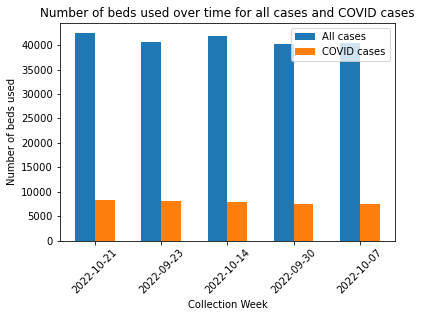

In [712]:
n = covid_and_all_beds_used_per_week.collection_week.shape[0]
ind = np.arange(n)
width = 0.3

plt.bar(
    ind,
    covid_and_all_beds_used_per_week.all_beds_used,
    width,
    label = "All cases"
    )

plt.bar(
    ind + width,
    covid_and_all_beds_used_per_week.covid_beds_used,
    width,
    label = "COVID cases"
    )

plt.xlabel("Collection Week")
plt.ylabel("Number of beds used")
plt.xticks(
    ind + width / 2,
    covid_and_all_beds_used_per_week.collection_week,
    rotation = 45
    )
plt.legend()
plt.title("Number of beds used over time for all cases and COVID cases")
plt.show()

## Additional Question 2

Create two tables showing the states with highest and lowest COVID cases.

In [713]:
covid_cases_per_state = pd.read_sql_query("select address.state as state, \
    sum(covid_info.covid_cases) as covid_cases \
    from ( \
        select hospital_pk, \
        coalesce(nullif(inpatient_beds_used_covid_7_day_avg, 'NaN'), 0) as covid_cases \
        from covid_info \
        ) as covid_info \
    left join ( \
        select hospital_pk, \
        state \
        from address \
        ) as address \
    on address.hospital_pk = covid_info.hospital_pk \
    group by state", conn)

In [714]:
covid_cases_map = px.choropleth(
      covid_cases_per_state,
      locations = covid_cases_per_state.state,
      locationmode = "USA-states",
      scope = "usa",
      color = np.log(covid_cases_per_state.covid_cases),
      color_continuous_scale = "Viridis_r")

covid_cases_map.update_layout(
      title_text = 'COVID Cases by State (on log scale)',
      title_x = 0.5
      )

covid_cases_map.show()

# Closing the SQL connection

In [715]:
conn.close()